# Ludo Project

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import cv2
import PIL
import os
import sys
import glob
import random

from pprint import pprint
from ipywidgets import Video

from PIL import Image
from PIL.ExifTags import TAGS

In [6]:
def imshow(a):
  a = a.clip(0, 255).astype('uint8')
  if a.ndim == 3:
    if a.shape[2] == 4:
      a = cv2.cvtColor(a, cv2.COLOR_BGRA2RGBA)
    else:
      a = cv2.cvtColor(a, cv2.COLOR_BGR2RGB)
  image = PIL.Image.fromarray(a)
  new_image = image.resize((250, 400))
  display(new_image)

In [7]:
#Video.from_file('videos\IMG_1912.mp4')
board = cv2.VideoCapture('videos\IMG_1912.mp4')
if board.isOpened():
    print('Video loaded')

board_width = int(board.get(3))
board_height = int(board.get(4))

print(board_height, board_width)

board_fps = board.get(cv2.CAP_PROP_FPS)
print(board_fps)

Video loaded
1920 1080
29.97002997002997


In [8]:
board.set(cv2.CAP_PROP_POS_FRAMES, 0)
ret, frame = board.read()
x, y, w, h = 300, 200, 100, 50 # simply hardcoded the values
track_window = (x, y, w, h)
roi = frame[y:y+h, x:x+w]

hsv_roi =  cv2.cvtColor(roi, cv2.COLOR_BGR2HSV)
mask = cv2.inRange(hsv_roi, np.array((0., 60.,32.)), np.array((180.,255.,255.)))
roi_hist = cv2.calcHist([hsv_roi], [0], mask, [180], [0, 180])
cv2.normalize(roi_hist, roi_hist, 0, 255, cv2.NORM_MINMAX)
term_crit = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 1 )

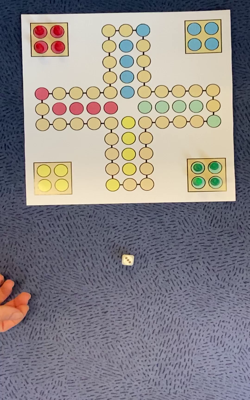

In [15]:
imshow(frame)

[] (227.25, 852.75)
[(227.25, 852.75)] (892.25, 838.5)
[(227.25, 852.75), (892.25, 838.5)] (212.5, 190.0)
[(227.25, 852.75), (892.25, 838.5), (212.5, 190.0)] (213.0, 189.25)
[(227.25, 852.75), (892.25, 838.5), (212.5, 190.0)] (877.25, 174.5)
[(227.25, 852.75), (892.25, 838.5), (212.5, 190.0), (877.25, 174.5)] (877.0, 174.5)
[(227.25, 852.75), (892.25, 838.5), (212.5, 190.0), (877.25, 174.5)] (553.5, 516.25)


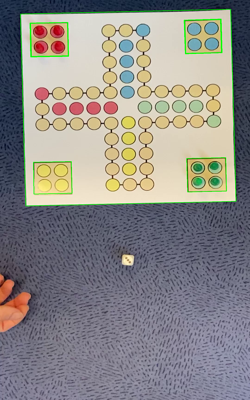

In [74]:
from scipy.spatial.distance import cdist

def closest_node(node, nodes):
    print(nodes, node)
    if len(nodes) == 0:
        return 0, np.Inf
    distances = cdist([node], nodes)
    return nodes[distances.argmin()], distances.min()

def add_shape(box, dict_boxes):
    center = np.mean(box, axis=0)
    center = (center[0], center[1])
    closest, distance = closest_node(center, list(dict_boxes.keys()))
    if distance > 100:
        dict_boxes[center] = box
    else:
        dict_boxes[closest] = (dict_boxes[closest] + box)/2

boxes = dict()
def find_squares(img):
    image = img.copy()
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blur = cv2.medianBlur(gray, 5)
    sharpen_kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
    sharpen = cv2.filter2D(blur, -1, sharpen_kernel)

    # Threshold and morph close
    thresh = cv2.threshold(sharpen, 100, 255, cv2.THRESH_BINARY_INV)[1]
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
    #close = cv2.morphologyEx(thresh, cv2.MORPH_ERODE, kernel, iterations=1) # good for token spotting
    close = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations=1)
    cnts, _ = cv2.findContours(close, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_NONE)

    #for contour, hier in zip(cnts, hierarchy[0]):
    for contour in cnts:
        approx = cv2.approxPolyDP(contour, 0.01* cv2.arcLength(contour, True), True)
        x, y , w, h = cv2.boundingRect(approx)
        aspectRatio = float(w)/h
        if  aspectRatio >0.9 and aspectRatio < 1.1 and cv2.contourArea(contour) > 100 and len(approx)< 10:
            ## BEGIN - draw rotated rectangle
            rect = cv2.minAreaRect(contour)
            box = cv2.boxPoints(rect)
            box = np.int0(box)
            #boxes[x] = box
            add_shape(box, boxes)
            cv2.drawContours(image,[box],0,(0,255,0),2)
        
        # TODO cluster into 5 subcategories: board, base1, base2, base3, base4
    imshow(image)
    


def base_recognition(frame):
    pass


def board_recognition(frame):
    pass


find_squares(frame)

In [75]:
boxes

{(227.25,
  852.75): array([[144, 778],
        [308, 775],
        [311, 927],
        [146, 931]], dtype=int64),
 (892.25,
  838.5): array([[806, 760],
        [975, 756],
        [978, 917],
        [810, 921]], dtype=int64),
 (212.5,
  190.0): array([[130.5, 111. ],
        [292. , 107.5],
        [295. , 268.5],
        [133.5, 271.5]]),
 (877.25,
  174.5): array([[796.5,  96.5],
        [953.5,  92.5],
        [957.5, 252.5],
        [801. , 256.5]]),
 (553.5,
  516.25): array([[  88,   67],
        [ 996,   44],
        [1019,  966],
        [ 111,  988]], dtype=int64)}

In [7]:
board_track = cv2.VideoWriter('./slow_board_small_meanshift.avi', cv2.VideoWriter_fourcc(*'DIVX'), board_fps, (board_width, board_height))

board.set(cv2.CAP_PROP_POS_FRAMES, 0)
while board.isOpened():
    ret, frame = board.read()

    if ret:
        hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
        dst = cv2.calcBackProject([hsv], [0], roi_hist, [0,180], 1)
        ret, track_window = cv2.meanShift(dst, track_window, term_crit)
        x, y, w, h = track_window
        board_track.write(cv2.rectangle(frame, (x,y), (x + w,y + h), 255, 2))
    else:
        break

board_track.release()

In [5]:
!ffmpeg -hide_banner -loglevel error -i slow_board_small_meanshift.avi -y slow_board_small_meanshift.mp4

In [6]:
Video.from_file('./slow_board_small_meanshift.mp4')

Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free...')